In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 42

NUM_ID_CHECK_SERVERS = 5     # number of id check queues
NUM_BODY_SCANNERS = 5        # number of body scanners/queues
T_INTER = 0.2                # mean passenger inter_arrival time (poisson distributed)
ID_CHECK_TIME = 0.75         # mean time each server takes to check an ID (exponentially distributed)
SCAN_TIME_LOW, SCAN_TIME_HIGH = 0.5, 1  # time taken at a scanner to scan a passenger (uniformly distributed)
SIM_TIME = 1000               # Simulation time in minutes

In [3]:
class IdCheck:
    """An ID check queue at the airport has a limited number of servers working in parallel.
    Passengers get on a queue and get their IDs checked within an exponential processing time
    with mean of 0.75 minutes.
    
    """
    def __init__(self, env, num_servers):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
    
        
    def check_passenger_id(self, passenger):
        """The id check process."""
        yield self.env.timeout(np.random.exponential(1/ID_CHECK_TIME))
        # print(f"{passenger}'s ID check completed")
        
class PersonalCheck:
    """Personal Check Queues with a limited number of personal scanners working in parallel. 
    Passengers get on the shortest queue after the ID check and when it's their turn, are processing
    at time that is uniformly distributed between 0.5 and 1 minute.
    
    """
    def __init__(self, env, capacity=1):
        self.env = env
        self.bodyscanner = simpy.Resource(env, capacity)
        
    def scan_passenger(self, passenger):
        """The id check process."""
        yield self.env.timeout(np.random.uniform(SCAN_TIME_LOW, SCAN_TIME_HIGH))
        # print(f"{passenger} has completed personal check")

processing_times = []        
def passenger(env, name, idchecker, scan_stations):
    """The passenger process. Each passenger has a name, and when they arrive at security check 
    joins an id check queue and waits their turn.
    
    After completing Id check, the passenger then joins the shortest personal check queue,
    completes personal scan, and proceeds to the boarding area.
    
    """
    # id check
    arrival_time = float(env.now)
    # print(f'{name} arrives at security check at {arrival_time:.2f}')
    with idchecker.server.request() as request:
        yield request
        
        # print(f'{name} starts id check at {float(env.now):.2f}')
        yield env.process(idchecker.check_passenger_id(name))
        
        # print(f'{name} completes id check at {float(env.now):.2f}')
        
    def _shortest_queue(scan_stations):
        shortest = min([len(scan_station.bodyscanner.queue) for scan_station in scan_stations])
        for scan_station in scan_stations:
            if len(scan_station.bodyscanner.queue) == shortest:
                return scan_station
    
    shortest_queue = _shortest_queue(scan_stations)
    
    #personal check
    # print(f'{name} joins personal scanner queue at {float(env.now):.2f}')
    with shortest_queue.bodyscanner.request() as request:
        yield request
        
        # print(f'{name} starts personal scan at {float(env.now):.2f}')
        yield env.process(shortest_queue.scan_passenger(name))
        
        exit_time = float(env.now)
        # print(f'{name} completes personal check at {exit_time:.2f}')
        
    processing_times.append({'name': name, 'processing_time': (exit_time - arrival_time)})
        
def setup(env, num_id_checkers, num_personal_scanners, t_inter):
    """Create a id check resource with a number of server, personal check resources,
    and a number of initial passengers at security. 
    Keep adding passengers at the inter-arrival rate
    """

    #create the IDcheck resource
    idchecker = IdCheck(env, num_id_checkers)
    
    scan_stations = []
    for _ in range(num_personal_scanners):
        station = PersonalCheck(env)
        scan_stations.append(station)
    
    
    # create ten initial passengers
    for i in range(10):
        env.process(passenger(env, f'Passenger {i}', idchecker, scan_stations))

        
    # Create more cars while the simulation is running
    while True:
        yield env.timeout(np.random.poisson(t_inter))
        i += 1
        env.process(passenger(env, f'Passenger {i}', idchecker, scan_stations))

Having completed the system set up and configuration above, I will run the simuation for 100 iterations of 1000 passengers going through the system, and plot a histogram of the mean processing time for each iteration.

As the first step, I run the simulation with 5 id checkers and 5 personal scan machines as defined earlier.

 Starting Airport Security Simulation


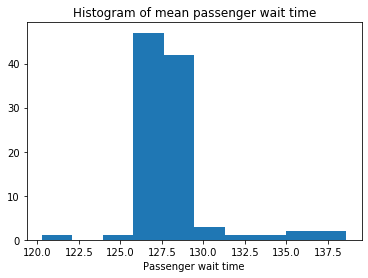

In [4]:
print(' Starting Airport Security Simulation')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, NUM_ID_CHECK_SERVERS, NUM_BODY_SCANNERS, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

The lowest procesing time that we get with this configuration is over 120 minutes! Definitely not good enough.

I will try gradually increasing the number of servers and number of body scanners to see where I can get acceptable results. I will lean more toward increasing the number of id check servers of course, as this will be cheaper to implement.

The next run of the simulation will use 10 id checkers and 10 scanners.

Airport Security


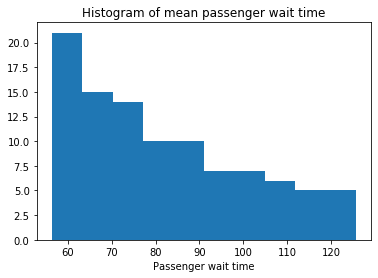

In [5]:
print('Airport Security')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, 10, 10, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

The mean passenger wait time has been reduced to between 60 and 120 minutes. I will try another doubling of both the number of id check servers, while holding the number of body scanners steady at 10.

Starting Airport Security Simulation


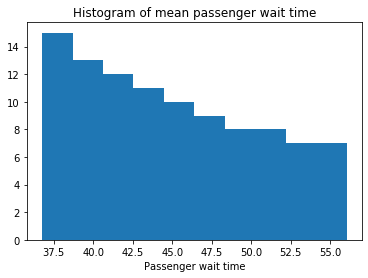

In [6]:
print('Starting Airport Security Simulation')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, 20, 10, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

Doubling the number of servers has reduced the average passenger wait time to between 37.5 and 55 minutes. This is an improvement, but not quite as good as we want. I will further increase the number of id check servers to 30.

Starting Airport Security Simulation


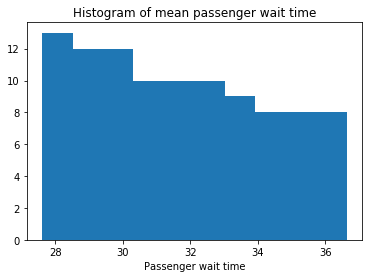

In [7]:
print('Starting Airport Security Simulation')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, 30, 10, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

We are now down to processing all passengers in under 40 minutes, on the average. I will add more body scanners to see if the desired average wait time of under 15 minutes can be achieved.

Starting Airport Security Simulation


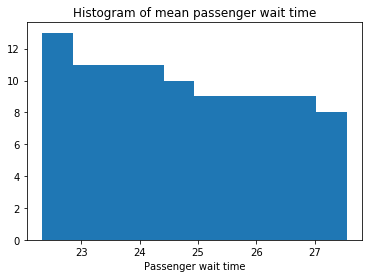

In [8]:
print('Starting Airport Security Simulation')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, 30, 15, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

We are still off, so more body scanners to the rescue!

Starting Airport Security Simulation


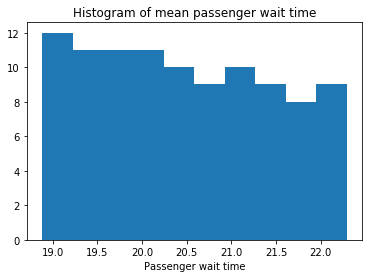

In [9]:
print('Starting Airport Security Simulation')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, 30, 30, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

We are still off the target wait time, so more id check servers please!

Starting Airport Security Simulation


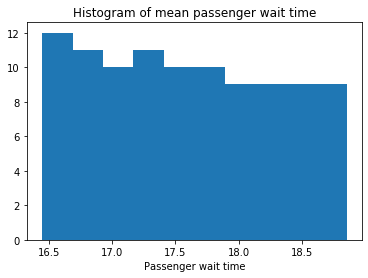

In [10]:
print('Starting Airport Security Simulation')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, 40, 30, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

Still off by a bit.

Starting Airport Security Simulation


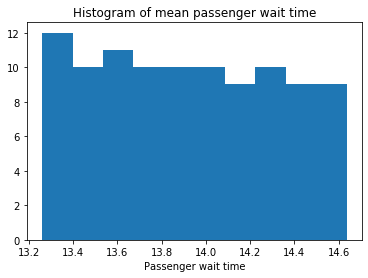

In [12]:
print('Starting Airport Security Simulation')
np.random.seed(RANDOM_SEED)

# Create an environment and start the setup process
mean_processing_times = []
for _ in range(100):
    
    env = simpy.Environment()
    env.process(setup(env, 70, 40, T_INTER))

    #Execute
    env.run(until=SIM_TIME)
    
    times = pd.DataFrame(processing_times)
    mean_time = times['processing_time'].mean()
    mean_processing_times.append(mean_time)
plt.hist(mean_processing_times)
plt.title('Histogram of mean passenger wait time')
plt.xlabel('Passenger wait time');

With f70 id checkers and 40 body scanning machines, we finally get average passenger wait times to under 15 minutes.

The actual number of id check servers and body scanners required to get average wait times to under 15 minutes is probably somewhere between the last two iterations, though not necessarily as the large as this last configuration.

Ideally, I would have included number of servers and number of body scanners as hyperparameters to tune in a loop and returned the minimum values that give the desired average processing time, but I spent a lot of time trying to figure out how to make the system work and couldn't devote enough time to cleaning up the code and enhancing the hyperparameter tuning.